In [44]:
from ultralytics import YOLO

In [45]:
import torch
torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Train Yolo

In [46]:
# Train YOLO 

# model = YOLO('yolov8n-obb.pt')

# results = model.train(data="Indonesian_License_Plate_Dataset (Bike)/data.yaml", epochs=80, device=1, imgsz=640)

Detect

In [47]:
# Model Declaration
model = YOLO('model-80epcs/obb/train/weights/best.pt')

In [48]:
# Demo Detection 
import os
import random

# Take random pic
dataset_location = 'C:/Users/Frederick/Documents/Project/Paperless Parking/Code/Object Detection/Indonesian_License_Plate_Dataset (Bike)'
random_file = random.choice(os.listdir(os.path.join(dataset_location, 'test', 'images')))
file_name = os.path.join(dataset_location, 'test', 'images', random_file)

# Static file
file_name = "test_material/TestRead_4.jpg"

results = model(file_name)
print(results)



image 1/1 c:\Users\Frederick\Documents\Project\Paperless Parking\Code\Object Detection\test_material\TestRead_4.jpg: 384x640 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'License_Plate', 1: 'cars', 2: 'motorcyle', 3: 'truck'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[158,  96, 180],
        [156,  94, 178],
        [155,  93, 177],
        ...,
        [ 21,  16,  13],
        [ 23,  18,  15],
        [ 26,  21,  18]],

       [[156,  94, 178],
        [155,  93, 177],
        [155,  93, 177],
        ...,
        [ 27,  22,  19],
        [ 27,  22,  19],
        [ 20,  15,  12]],

       [[153,  91, 175],
        [153,  91, 175],
        [155,  93, 177],
        ...,
        [ 28,  23,  20],
        [ 29,  24,  21],
        [ 24,  19,  16]],

       ...,

       [[ 88, 119, 150],
        [ 91, 12

Display the plate

27000000
<class 'numpy.ndarray'>
120408
License Plates: [[array([[[ 76,  37,  50],
        [ 73,  33,  46],
        [ 70,  32,  43],
        ...,
        [ 71,  18,  21],
        [ 69,  16,  19],
        [ 72,  19,  22]],

       [[ 70,  28,  41],
        [ 68,  26,  38],
        [ 66,  25,  37],
        ...,
        [ 67,  14,  17],
        [ 66,  13,  16],
        [ 72,  19,  22]],

       [[ 74,  30,  43],
        [ 73,  29,  42],
        [ 74,  31,  44],
        ...,
        [ 66,  13,  16],
        [ 66,  13,  16],
        [ 70,  17,  20]],

       ...,

       [[ 46,  25,  33],
        [ 37,  16,  24],
        [ 37,  16,  24],
        ...,
        [157, 109, 117],
        [138,  89,  97],
        [120,  71,  79]],

       [[ 51,  30,  38],
        [ 43,  22,  30],
        [ 47,  26,  34],
        ...,
        [159, 113, 121],
        [141,  93, 101],
        [118,  70,  78]],

       [[ 54,  33,  41],
        [ 50,  29,  37],
        [ 57,  36,  44],
        ...,
        [161, 11

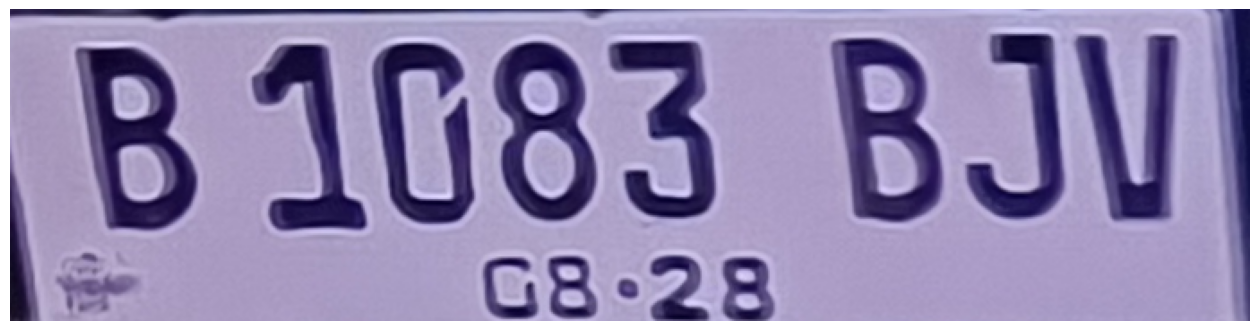

In [49]:
import supervision as sv
import cv2
import numpy as np

image = cv2.imread(file_name)
print(image.size)
original_image = image.copy()
print(type(original_image))
detections = sv.Detections.from_ultralytics(results[0])
oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=image,
    detections=detections
)

def extract_license_plates(image, detections):
    license_plates = []
    for i,class_id in enumerate(detections.class_id):
        if detections.data['class_name'][i] == 'License_Plate':
            BoxCoordinate= np.float32(detections[i].data['xyxyxyxy'][0])
            idxPoint1 = np.argmin(BoxCoordinate[:, 1])
            xCurrent = BoxCoordinate[idxPoint1][0]
            xFoward = BoxCoordinate[(idxPoint1 + 1) % 4][0]
            xBackward = BoxCoordinate[(idxPoint1 - 1) % 4][0]
            if(xFoward <= xCurrent):
                xBackward, xFoward = xFoward, xBackward
                
            if((xFoward - xCurrent == 0) | (xBackward - xCurrent == 0) ):
                x1,y1,x2,y2 = class_id.xyxy
                x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
                imageCropped = original_image[y1:y2,x1:x2]
                area = (x2 - x1) * (y2 -y1)
                license_plates.append([imageCropped,area,i])
                continue
            elif((xFoward - xCurrent) > (xCurrent - xBackward)):
                idxPoint2 = np.argmax(BoxCoordinate[:, 0])
                idxPoint3 = np.argmin(BoxCoordinate[:, 0])
                idxPoint4 = np.argmax(BoxCoordinate[:, 1])
            else:
                idxPoint2 = idxPoint1
                idxPoint3 = np.argmax(BoxCoordinate[:, 1])
                idxPoint1 = np.argmin(BoxCoordinate[:, 0])
                idxPoint4 = np.argmax(BoxCoordinate[:, 0])
            
            # top left corner, top right corner, bottom left corner, bottom right corner
            val = 3
            point1 = np.array([BoxCoordinate[idxPoint1][0] + val, BoxCoordinate[idxPoint1][1] + val], dtype="float32")
            point2 = np.array([BoxCoordinate[idxPoint2][0] - val, BoxCoordinate[idxPoint2][1] + val], dtype="float32")
            point3 = np.array([BoxCoordinate[idxPoint3][0] + val, BoxCoordinate[idxPoint3][1] - val], dtype="float32")
            point4 = np.array([BoxCoordinate[idxPoint4][0] - val, BoxCoordinate[idxPoint4][1] - val], dtype="float32")
            points = [point1, point2, point3, point4]

            width = int(max(np.linalg.norm(point2 - point1), np.linalg.norm(point4 - point2)))
            height = int(max(np.linalg.norm(point3 - point1), np.linalg.norm(point4 - point2)))
            dst = np.array([
                [0, 0],
                [width - 1, 0],
                [0, height - 1],
                [width - 1, height - 1],
            ], dtype="float32")

            M = cv2.getPerspectiveTransform(np.float32(points), dst)
            imageCropped = cv2.warpPerspective(original_image, M, (width, height))
            area = width * height
            print(area)
            license_plates.append([imageCropped,area,i])
    return license_plates


license_plates = extract_license_plates(image, detections)
print(f"License Plates: {license_plates}")
nearest_license_plate = max(license_plates, key=lambda x: x[1])
sv.plot_image(image=nearest_license_plate[0], size=(16, 16))

Read The Plate

In [50]:
import easyocr
import cv2 as cv
import matplotlib.pyplot as plt

def detect_text_from_image(image_path):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(image_path)
    text = ""
    for result in results:
        text += result[1] + " "
    return text

# Usage example
# print(nearest_license_plate[0])
DenoiseImage = cv.fastNlMeansDenoising(nearest_license_plate[0], None, 7, 15, 13)
GrayImage = cv.cvtColor(DenoiseImage, cv2.COLOR_BGR2GRAY)
_, image = cv2.threshold(GrayImage, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY )
text = detect_text_from_image(image).upper()
# plt.hist(image.ravel(), 256, [0, 256])
# sv.plot_image(image=image, size=(16, 16))

In [51]:
import re

remove_chars = '.,@#!$%^&*()[]{}|\\:;\'"<>?/`~_'
translation_table = str.maketrans('', '', remove_chars)

def cleanText(text : str):

    MissreadPossibility = {
        "8": "B",
        "1": "I", 
        "0": "O",
        "4": "H",
        "2": "Z"
    }

    MissreadPossibilityNum = {
        "B":"8",
        "I":"1", 
        "O":"0",
        "H":"4",
        "Z":"2"
    }

    text = text.replace(' ','')
    text = list(text)
    word_section = 1
    word_count = 0

    for i,char in enumerate (text[:-1]):
        if(word_section == 3):
            word_count+=1
        if(word_section % 2 == 1):
            if text[i] in MissreadPossibility:
                text[i] = MissreadPossibility[text[i]]
        else:
            if text[i] in MissreadPossibilityNum:
                text[i] = MissreadPossibilityNum[text[i]]
        if (char.isalpha() and text[i + 1].isdigit()) or (char.isdigit() and text[i + 1].isalpha()):
            word_section+=1
        if (word_section >= 4) or word_count >= 3:
            return ''.join(text)[0:i+1].translate(translation_table)
    return ''.join(text).translate(translation_table)

print(cleanText(text))

B1083BJV
